# Compare Gradient Descent Variations

This Notebook will explore the differences between traditional (Batch) Gradient Descent, Stochastic Gradient Descent and Mini-Batch Gradient Descent.

## Background

#### Import dependencies

In [1]:
import math
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook

## Generate our dummy data

In [2]:
# number of random data points to generate
N = 10000

In [3]:
# generate array of random floats for our independent variable, x (values between 0 and 1 as default)
x = np.random.rand(N)
x = np.array(sorted(x))

In [4]:
# to make this a bit more interesting than a simple linear problem, we will also introduce an x^2 dependency
x2 = np.square(x)

In [5]:
# define our parameter values that will be used to generate our dependent variable values, y
a0, a1, a2 = 3, 2, -5

In [6]:
# generate our y values based on our x values, our parameters and introduce some noise (we don't want perfect data!)
y = a0 + a1*x + a2*x2 + np.random.normal(0, 0.2, N)

In [7]:
# also allow ourselves to plot our underlying distribution
y_curve = a0 + a1*x + a2*x2

#### Plot our data

<IPython.core.display.Javascript object>


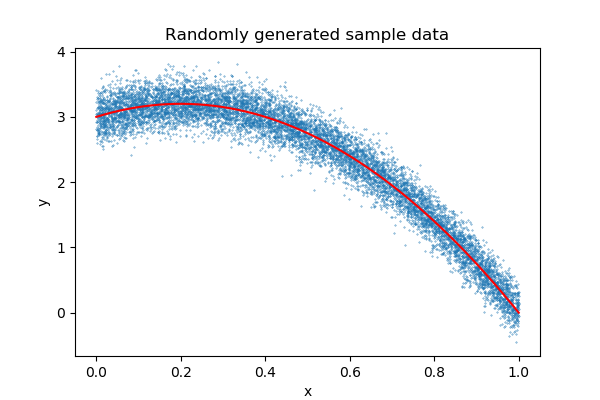

In [8]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Randomly generated sample data')

plt.plot(x, y_curve, color="red")
plt.scatter(x, y, marker='o', s=0.1)

## Create X matrix for use in Gradient Descent

In [9]:
def X_for_gd(*features):
    '''
    Creates X matrix containing all feature values plus bias term for input into cost func and grad desc algos
    
    :param *features: (m, ) ndarrays for all features values recorded at each observation (m total observations) 
    
    :return: (m, f+1) ndarray
    '''
    # check we have actually passed in some features
    assert len(features) > 0
    
    # initiate X with bias term
    X = np.ones(len(x)).reshape(-1, 1)
    
    for feature in features:
        
        # check all features have the same shape
        assert feature.shape == features[0].shape
        
        # add all feature values to X
        X = np.concatenate((X, feature.reshape(-1, 1)), axis=1)
        
    return X

##### Test our new function

In [10]:
X_for_gd(x, x2).shape

(10000, 3)

## Cost Function

In [11]:
def cost(X, y, theta):
    '''
    Calculates the mean square error (MSE) total cost
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of proposed parameter values for which the cost must be determined
    
    :return: float of MSE cost
    '''
    
    # number of observations made
    m = len(y)
    # our hypothesis i.e. our guess at what y we would obtain given features X and parameters theta
    h = X.dot(theta)
    
    return (1/(2*m)) * np.sum( (h-y)**2 )

In [12]:
def cost_grad(X, y, theta):
    '''
    Calculates the gradient of the cost function w.r.t. to each parameter 
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of proposed parameter values for which the cost gradient must be determined
    
    :return: (f+1, ) ndarray of the gradient of the cost function w.r.t. each theta parameter
    ''' 
    
    # number of observations made
    m = len(y)
    # our hypothesis i.e. our guess at what y we would obtain given features X and parameters theta
    h = X.dot(theta)
    
    return (1/m) * (X.T.dot((h-y)))

##### Test our new functions

In [13]:
X = X_for_gd(x, x2)
theta = np.random.rand(1, X.shape[1])
theta = list(theta[0])

In [14]:
cost(X, y, theta)

2.708398953558209

In [15]:
cost_grad(X, y, theta)

array([-2.0092947 , -0.68485383, -0.32429069])

## Batch Gradient Descent

In [16]:
def batch_gd(X, y, theta=list(np.random.rand(1, X.shape[1])[0]), alpha=0.01, num_iter=100):
    '''
    Use feature data from all observations to optimise theta parameters at each iteration
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of initially proposed parameter values. These are updated in this function
    :param alpha: float of the learning rate - determines how big our 'steps' are
    :param num_iter: int stating the number of steps we want to take to optimise our theta parameters
    
    :return theta: (f+1) dimensional list of the final, optimised theta parameters
    :return c: float our final cost corresponding to the our optimised theta parameters
    :return cost_record: (num_iter+1, ) ndarray containing record of MSE cost at each iteration (+ init value)
    :return theta_record: (num_iter+1, f+1) ndarray containing record of theta parameters at each iteration (+ init values)
    '''     

    # number of observations made
    m = len(y)
    
    # initiate ndarrays that will be contain a record of how our theta and cost values changed with each iteration
    cost_record = np.empty(num_iter+1)
    theta_record = np.empty((num_iter+1, len(theta)))
    
    theta_record[0, :] = theta
    cost_record[0] = cost(X, y, theta)
    
    # update our theta values with each iteration to minimise our cost function
    for i in range(1, num_iter+1):
        
        # our hypothesis i.e. our guess at what y we would obtain given features X and parameters theta
        h = X.dot(theta)
        
        # calculate new theta values that reduce our total cost and add these to our record
        theta = theta - (alpha * cost_grad(X, y, theta))
        theta_record[i, :] = theta.T
        
        # calculate the MSE cost given the updated theta
        c = cost(X, y, theta)
        cost_record[i] = c
        
    return theta, c, cost_record, theta_record

##### Test our batch gradient descent algo and plot its performance

In [19]:
X = X_for_gd(x, x2)
opt_theta, final_cost, cost_rec, theta_rec = batch_gd(X, y, alpha=0.1, num_iter=200)

<IPython.core.display.Javascript object>


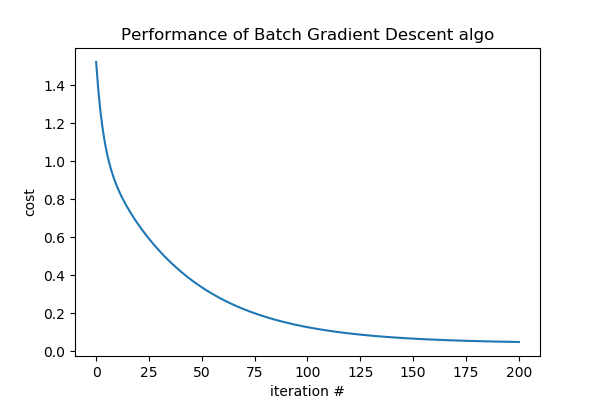

In [20]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('iteration #')
ax.set_ylabel('cost')
ax.set_title('Performance of Batch Gradient Descent algo')

plt.plot(np.arange(0, len(cost_rec)), cost_rec)

## Stochastic Gradient Descent

In [ ]:
def stochastic_gd(X, y, theta=list(np.random.rand(1, X.shape[1])[0]), alpha=0.01, num_iter=100):
    '''
    Use feature data from just one observation to optimise theta parameters at each iteration
    
    :param y: (m, ) ndarray containing recorded value for 'm' observations
    :param X: (m, f+1) ndarray containing features values for each data point, plus bias term of 1 in first column
    :param theta: (f+1) dimensional list of initially proposed parameter values. These are updated in this function
    :param alpha: float of the learning rate - determines how big our 'steps' are
    :param num_iter: int stating the number of steps we want to take to optimise our theta parameters
    
    :return theta: (f+1) dimensional list of the final, optimised theta parameters
    :return c: float our final cost corresponding to the our optimised theta parameters
    :return cost_record: (num_iter+1, ) ndarray containing record of MSE cost at each iteration (+ init value)
    :return theta_record: (num_iter+1, f+1) ndarray containing record of theta parameters at each iteration (+ init values)
    '''    